## Notes on COVID-19 Modeling

Description


In [1]:
import sys
# Install required packages
!{sys.executable} -mpip -q install matplotlib seaborn statsmodels pandas publicdata metapack

%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import rowgenerators as rg
import publicdata as pub
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import weibull_min, lognorm, logistic, norm
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.integrate import odeint

sns.set(color_codes=True)

Epidemic Modeling 101: Or Why Your CoVID19 Exponential Fits Are Wrong. https://medium.com/data-for-science/epidemic-modeling-101-or-why-your-covid19-exponential-fits-are-wrong-97aa50c55f8. Accessed 30 Mar. 2020.

Linton, Natalie M., et al. “Incubation Period and Other Epidemiological Characteristics of 2019 Novel Coronavirus Infections with Right Truncation: A Statistical Analysis of Publicly Available Case Data.” Journal of Clinical Medicine, vol. 9, no. 2, 2, Multidisciplinary Digital Publishing Institute, Feb. 2020, p. 538. www.mdpi.com, doi:10.3390/jcm9020538.





There are four distributions that are used to fit to the cumulative number of cases or deaths. Are the really much different?

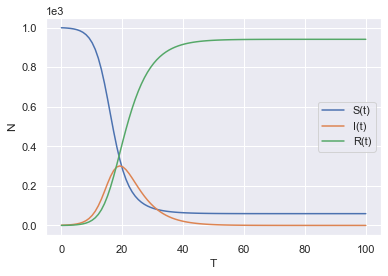

In [41]:





N = 1000
S = N - 1
I = 1
R = 0
beta = .6 # infection rate
gamma = 0.2 # recovery rate

R0 = beta / gamma

# differential equatinons
def diff(sir, t):
    # sir[0] - S, sir[1] - I, sir[2] - R
    dsdt = - (beta * sir[0] * sir[1])/N
    didt = (beta * sir[0] * sir[1])/N - gamma * sir[1]
    drdt = gamma * sir[1]
    #print (dsdt + didt + drdt)
    dsirdt = [dsdt, didt, drdt]
    return dsirdt


# initial conditions
sir0 = (S, I, R)

# time points
t = np.linspace(0, 100, num=100)

# solve ODE
# the parameters are, the equations, initial conditions, 
# and time steps (between 0 and 100)
sir = odeint(diff, sir0, t)



plt.plot(t, sir[:, 0], label='S(t)')
plt.plot(t, sir[:, 1], label='I(t)')
plt.plot(t, sir[:, 2], label='R(t)')

plt.legend()

plt.xlabel('T')
plt.ylabel('N')

# use scientific notation
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.show()

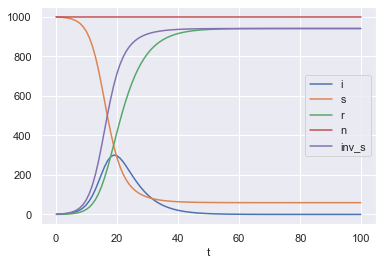

In [3]:
df = pd.DataFrame({'t': t, 'i':sir[:, 1], 's': sir[:, 0] , 'r': sir[:, 2] })
df['n'] = df.i + df.r + df.s
df = df.groupby(t.round(0)).mean().set_index('t')

df['inv_s'] =  1000 - df.s
df.plot()


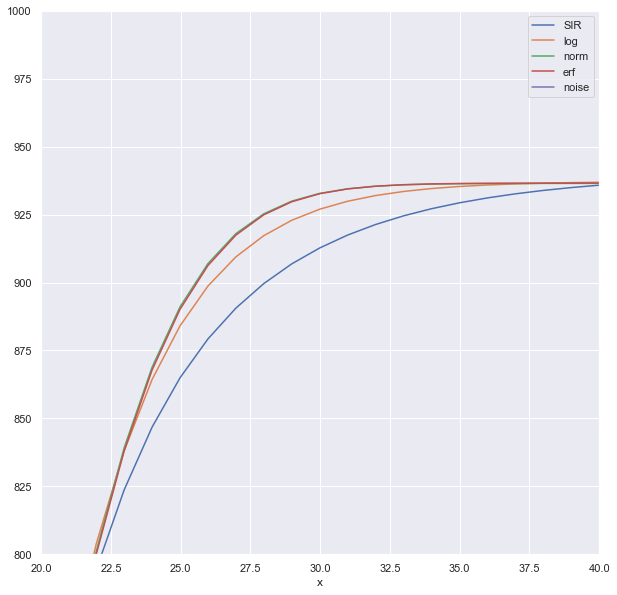

In [27]:
##
## Create a base logistic function, centered at 1, 
## then fit other distributions to it. 
##

from scipy.stats import weibull_min, lognorm, logistic, norm

x = df.index
base_dist = df.inv_s

cdf = pd.DataFrame({
    'x': x,
    'SIR': base_dist, 

})

#
# Logistic
#
def func_logistic(x, loc, scale, a): # popt = (14,4, 800)
    return a*logistic.cdf(x, loc, scale)
func_logistic.popt =  (14,4, 800)

popt, pcov = curve_fit(func_logistic, x, base_dist, p0=func_logistic.popt)
cdf['log'] = func_logistic(x, *popt)



#
# Weibul
#

if False:
    def func_weibull(x, loc ,scale, a):
        return weibull_min.cdf(x,loc, scale)
    func_weibull.popt =  (14,4, 800)

    popt, pcov = curve_fit(func_weibull, x, base_dist, p0=func_weibull.popt)
    cdf['weibul'] = func_weibull(x, *popt)


#
# Lognorm
#

if False:
    def func_ln(x, loc, scale, a):
        return a*lognorm.cdf(x, loc, scale)
    func_ln.popt =  (14,4, 800)

    popt, pcov = curve_fit(func_ln, x, base_dist, p0=func_ln.popt)

    cdf['lognorm'] = func_ln(x, *popt)

#
# Normal
#

def func_norm(x, loc, scale, a):
    return a*norm.cdf(x, loc, scale)
func_norm.popt =  (14,4, 800)

popt, pcov = curve_fit(func_norm, x, base_dist, p0=func_norm.popt)

cdf['norm'] = func_norm(x, *popt)


#
# Error Function
#

def func_erf(x, loc, scale, a, b):
    return a*erf( (x-loc) / scale ) + b
func_erf.popt = (50,20,3000,3000)

popt, pcov = curve_fit(func_erf, x, base_dist, p0=func_erf.popt)

cdf['erf'] = func_erf(x, *popt)

cdf['noise'] =  cdf.SIR * .05 * np.random.normal(size=len(cdf) )



cdf = cdf.set_index('x')

fig, ax = plt.subplots(1, 1, figsize=(10,10))
#ax.set_xlim(0,20)
#ax.set_ylim(0,200)
ax.set_xlim(20,40)
ax.set_ylim(800,1000)

cdf.plot(ax=ax)


In [ ]:
# Compare the similarities of the distibutions. The 
# Kologorov-Smirnov test assesses how likely is it that
# two sets of samples were drawn from the same distribution. 
# https://en.m.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
from scipy.stats import ks_2samp

dist = pdf

index = [] 
for a,b in dist.corr().stack().index: # Cheap way to generate all combinations
    idx = tuple(sorted([a,b]))
    if idx in index: # or a == b:
        continue
    else:
        index.append(idx)

df = pd.DataFrame(index=pd.MultiIndex.from_tuples(index, names=['a', 'b']))
df['ks_mean'] = np.nan 
df['ks_p'] = np.nan 
    
for idx in df.index:
   
    try:
        v = ks_2samp(dist[idx[0]],dist[idx[1]])
    except KeyError:
        print(a, b)
        pass
    
    df.at[idx,'ks_stat']  = v[0]
    df.at[idx,'ks_p'] = v[1]
    
    
df

In [106]:
from functools import lru_cache


def run_sir(t, N, beta, gamma):
    
    #N = 1000
    S = N - 1
    I = 1
    R = 0
    #beta = .6 # infection rate
    #gamma = 0.2 # recovery rate

    R0 = beta / gamma

    # differential equatinons
    def diff(sir, t):
        # sir[0] - S, sir[1] - I, sir[2] - R
        dsdt = - (beta * sir[0] * sir[1])/N
        didt = (beta * sir[0] * sir[1])/N - gamma * sir[1]
        drdt = gamma * sir[1]
        #print (dsdt + didt + drdt)
        dsirdt = [dsdt, didt, drdt]
        return dsirdt

    # initial conditions
    sir0 = (S, I, R)

    
    
    # solve ODE
    # the parameters are, the equations, initial conditions, 
    # and time steps (between 0 and 100)
    sir = odeint(diff, sir0, t)

    return pd.Series( N - sir[:, 0], index=t)

    

def sir_fit_func(t, N, beta, gamma, a, b):
        
    try:
        t = t.round()
        s = run_sir(t, N, beta, gamma)
        return (a*s).shift(int(b.round()))
            
    except AttributeError: # It is a scalar, not an array
        print(type(t), t)
        raise
        t_ = np.linspace(0, 99, num=100)
        s = run_sir(t_, N, beta, gamma)
        print(t)
        
    

sir_fit_func.popt = (1000, .6, .2, 1, 0)

popt, pcov = curve_fit(sir_fit_func, x.values, base_dist, p0=sir_fit_func.popt)

sirf = sir_fit_func(t, *popt)

print(popt)

#cdf['norm'] = func_norm(x, *popt)



[1.01402880e+03 6.02017282e-01 2.02310428e-01 9.87929083e-01
 0.00000000e+00]


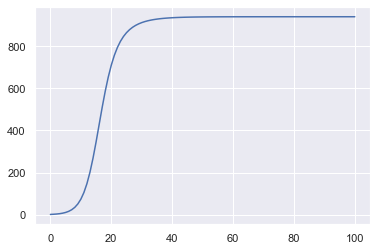